In [1]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
import random
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import os 
os.chdir('C:/Users/Administrator/Desktop/魔镜杯数据')
import score_card as sc

C:\Users\Administrator\Anaconda3\envs\py3\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# Master数据
df1 = pd.read_csv('feature_select_data1.csv',encoding='gb18030')
df1.shape

(49701, 161)

In [3]:
# 排序特征数据
rank_df = pd.read_csv('rank_feature.csv',encoding='gbk')
rank_df.shape

(49701, 124)

In [4]:
# periods衍生特征数据
periods_df = pd.read_csv('periods_feature.csv',encoding='gbk')
periods_df.shape

(49701, 51)

In [5]:
# 原生特征（不含排序特征和periods衍生特征）
feature1 = list(df1.columns)
# 排序特征和periods衍生特征
feature2 = list(rank_df.columns)+list(periods_df.columns)

In [6]:
# 对feature2进行随机打乱顺序
random.shuffle(feature2)

In [7]:
# 合并数据集
df = pd.concat([df1,rank_df,periods_df],axis=1)
df.shape

(49701, 336)

In [8]:
# 保存用户id
data_idx = df.Idx

In [9]:
# 定义lightgbm的bagging函数
def bagging_lightgbm(feature_fraction,bagging_fraction,ramdom_seed,n_feature):
    
    select_fea = feature1+feature2[:n_feature]
    
    data = df.loc[:,select_fea]
    train_x = data[data.sample_status=='train'].drop(['sample_status','target','Idx'],axis=1)
    train_y = data[data.sample_status=='train']['target']
    test_x = data[data.sample_status=='test'].drop(['sample_status','target','Idx'],axis=1)
    test_y = data[data.sample_status=='test']['target']
    
    test_user_id = list(data[data.sample_status=='test']['Idx'])
    
    
    dtrain = lgb.Dataset(train_x,train_y)
    dtest = lgb.Dataset(test_x,test_y)
    
    params={
        'boosting_type':'gbdt',
        'metric':'auc',
        'num_leaves':30,
        'min_data_in_leaf':20,
        'min_sum_hessian_in_leaf':0.001,
        'bagging_fraction':bagging_fraction,
        'feature_fraction':feature_fraction,
        'learning_rate':0.005,
    }
    
    #  寻找最佳的迭代次数
    cv_result = lgb.cv(train_set=dtrain,
                       early_stopping_rounds=10,
                       num_boost_round=1000,
                       nfold=5,
                       metrics='auc',
                       seed=0,
                       params=params,
                       stratified=True,
                       shuffle=True)
    max_auc = max(cv_result['auc-mean'])
    num_round = len(cv_result['auc-mean'])
    
    model = lgb.train(train_set=dtrain,early_stopping_rounds=10,num_boost_round=num_round,valid_sets=dtest,params=params)
    
    model_pre = list(model.predict(test_x))
    result_df = pd.DataFrame({'Idx':test_user_id,
                              'score':model_pre})
    return result_df

# 对随机种子，bagging_fraction，feature_fraction及特征数量进行随机扰动
random_seed = list(range(2018))
bagging_fraction = [i/1000.0 for i in range(500,1000)]
feature_fraction = [i/1000.0 for i in range(500,1000)]
n_feature = list(range(50,174,2))

random.shuffle(random_seed)
random.shuffle(bagging_fraction)
random.shuffle(feature_fraction)
random.shuffle(n_feature)

In [ ]:
import time 
a=  time.time()
result_df_list=[]
# 建立30个子模型，保存各个子模型输出的结果
for i in range(30):
    result_df = bagging_lightgbm(feature_fraction=feature_fraction[i],
                                 n_feature=n_feature[i],
                                 ramdom_seed=random_seed[i],
                                 bagging_fraction=bagging_fraction[i])
    result_df_list.append(result_df)
# 对30个子模型的结果average，得到bagging模型的最终结果
prep_list = [list(x['prep']) for x in result_df_list]
bagging_prep= list(np.sum(score_list,axis=0)/30)
b = time.time()
print('运行时间:{}'.format(round(b-a,0)))

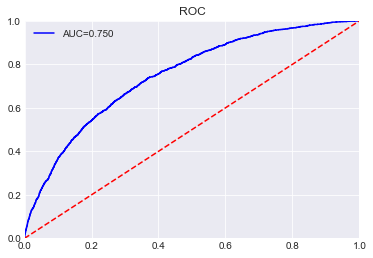

In [103]:
# bagging模型的AUC
test_y = list(df[df.sample_status=='test']['target'])
sc.plot_roc(y_label=test_y,y_pred=ss)